<a href="https://colab.research.google.com/github/paratesai316/Six-Degrees-of-Air-Travel/blob/main/Six_Degrees_of_Air_Travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the Global Flight Network ✈️

## Project Overview

This project explores the connectivity of the global air travel network, inspired by the "six degrees of separation" concept. Using the OpenFlights dataset, we model the world's airports and flight paths as a graph to answer several key questions:

1.  **How many flights does it take to connect any two random airports in the world?**
2.  How does this change if we account for the fact that people are more likely to travel to or from major cities?
3.  What is the average shortest **travel distance** required to connect two airports, considering realistic travel patterns?

To answer these questions, this notebook builds and analyzes four distinct models:
* **Model 1 & 2:** A foundational analysis using an unweighted graph to find the minimum number of flights (path length) between random airports using a Breadth-First Search (BFS) approach.
* **Model 3:** A more realistic simulation that introduces a **population bias**. Airports in more populous cities are more likely to be selected, modeling real-world travel demand.
* **Model 4:** The most advanced model, which constructs a **distance-weighted graph** using the Haversine formula for each flight path. It then combines the population bias with **Dijkstra's algorithm** to find the shortest possible travel distance in kilometers.

**Technologies Used:** `pandas`, `networkx`, `matplotlib`, `seaborn`, `geonamescache`

Loading airport and route data
Found 6072 active airports and 66923 direct routes.
Graph with 3257 airports and 18931 connections.


100%|██████████| 100000/100000 [00:11<00:00, 8438.52it/s]



Average number of flights between any two airports: 3.97
   (Based on 98333 reachable pairs)
   Found 1667 pairs that were not connected at all.


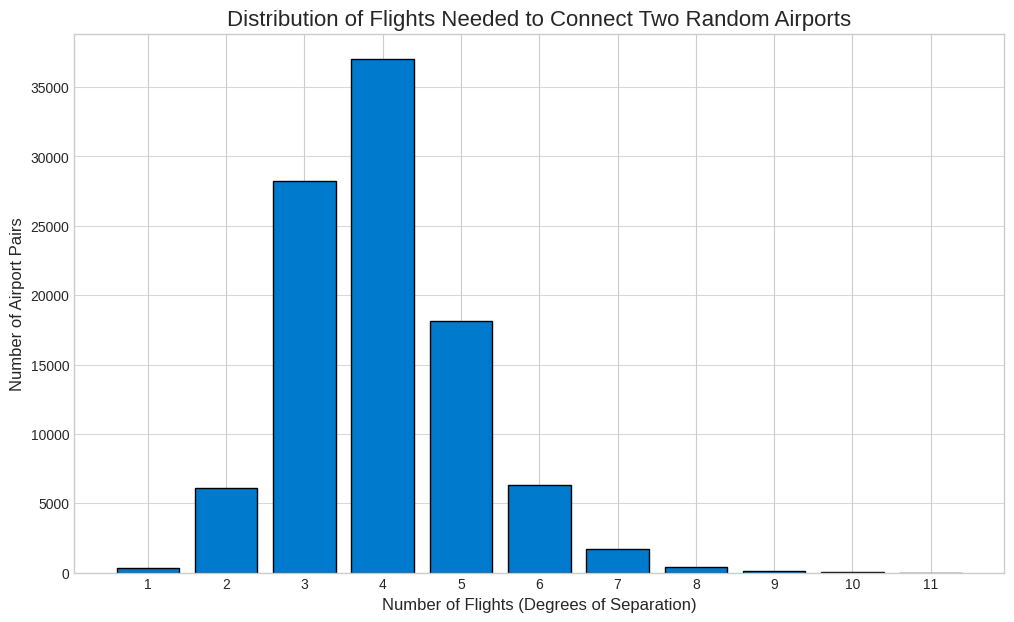

In [1]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

#Data loading
print("Loading airport and route data")

airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
routes_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

airport_cols = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source']
route_cols = ['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment']

airports = pd.read_csv(airports_url, names=airport_cols, na_values='\\N')
routes = pd.read_csv(routes_url, names=route_cols, na_values='\\N')

#Data cleaning
active_airports = airports[(airports['Type'] == 'airport') & (airports['IATA'].notna())]
valid_iata_codes = set(active_airports['IATA'])

valid_routes = routes[
    (routes['Stops'] == 0) &
    (routes['Source airport'].isin(valid_iata_codes)) &
    (routes['Destination airport'].isin(valid_iata_codes))
]

print(f"Found {len(valid_iata_codes)} active airports and {len(valid_routes)} direct routes.")

#Airport network graph construction

G = nx.Graph()

for index, row in valid_routes.iterrows():
    source = row['Source airport']
    dest = row['Destination airport']
    G.add_edge(source, dest)

graph_nodes = list(G.nodes())
print(f"Graph with {G.number_of_nodes()} airports and {G.number_of_edges()} connections.")

#Breadth-first search to find least number of flights
num_samples = 100000

path_lengths = []
unreachable_pairs = 0

for _ in tqdm(range(num_samples)):
    start_node, end_node = random.sample(graph_nodes, 2)

    try:
        length = nx.shortest_path_length(G, source=start_node, target=end_node)
        path_lengths.append(length)
    except nx.NetworkXNoPath:
        unreachable_pairs += 1

#Analysis and vizualization

if path_lengths:
    average_flights = sum(path_lengths) / len(path_lengths)
    print(f"\nAverage number of flights between any two airports: {average_flights:.2f}")
    print(f"   (Based on {len(path_lengths)} reachable pairs)")
    if unreachable_pairs > 0:
        print(f"   Found {unreachable_pairs} pairs that were not connected at all.")

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    plt.hist(path_lengths, bins=range(1, max(path_lengths) + 2), align='left', rwidth=0.8, color='#007acc', edgecolor='black')
    plt.title('Distribution of Flights Needed to Connect Two Random Airports', fontsize=16)
    plt.xlabel('Number of Flights (Degrees of Separation)', fontsize=12)
    plt.ylabel('Number of Airport Pairs', fontsize=12)
    plt.xticks(range(1, max(path_lengths) + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("Could not find any connected paths in the samples.")

--2025-10-12 17:45:37--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2377148 (2.3M) [text/plain]
Saving to: ‘routes.dat’

routes.dat          100%[===================>]   2.27M  11.3MB/s    in 0.2s    

2025-10-12 17:45:37 (11.3 MB/s) - ‘routes.dat’ saved [2377148/2377148]

--2025-10-12 17:45:37--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127225 (1.1M) [text/plain

  0%|          | 0/100000 [00:00<?, ?it/s]


Analysis Results
Number of random pairs tested: 100000
Pairs with a connecting route: 97170
Pairs with no connecting route: 2830
Average number of flights between connected airports: 4.07
Most common number of flights needed: 4




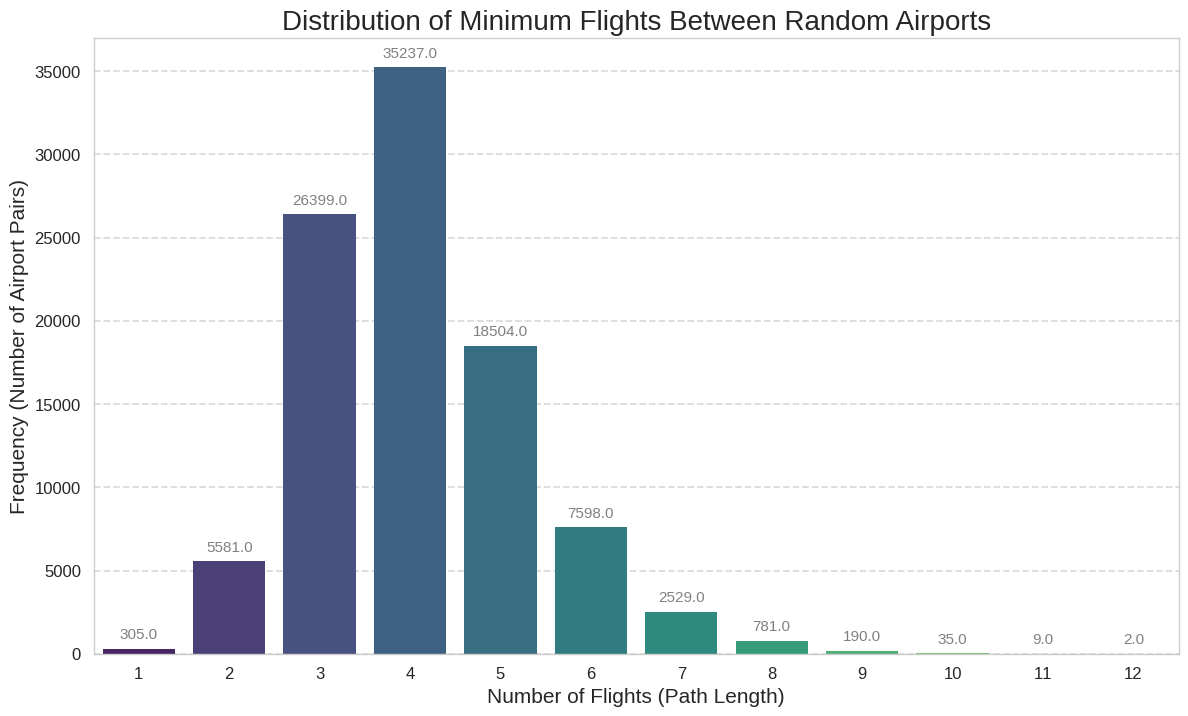

In [2]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat -O routes.dat
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat -O airports.dat

#Data loading
airports_cols = [
    'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',
    'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
    'Tz database time zone', 'Type', 'Source'
]
routes_cols = [
    'Airline', 'Airline ID', 'Source airport', 'Source airport ID',
    'Destination airport', 'Destination airport ID', 'Codeshare',
    'Stops', 'Equipment'
]
airports = pd.read_csv('airports.dat', header=None, names=airports_cols, na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=routes_cols, na_values='\\N')

#Data cleaning
routes.dropna(subset=['Source airport ID', 'Destination airport ID'], inplace=True)

routes['Source airport ID'] = routes['Source airport ID'].astype(int)
routes['Destination airport ID'] = routes['Destination airport ID'].astype(int)

print(f"Found {len(airports)} airports and {len(routes)} routes.")

#Airport network graph construction
G = nx.from_pandas_edgelist(
    routes,
    source='Source airport ID',
    target='Destination airport ID',
    create_using=nx.DiGraph()
)

airport_nodes = list(G.nodes())

print(f"Graph with {G.number_of_nodes()} airports (nodes) and {G.number_of_edges()} flights (edges).")

#Breadth-first search to find least number of flights
num_samples = 100000
path_lengths = []
no_path_count = 0

for _ in tqdm(range(num_samples)):
    source_airport, target_airport = random.sample(airport_nodes, 2)

    try:
        length = nx.shortest_path_length(G, source=source_airport, target=target_airport)
        path_lengths.append(length)
    except nx.NetworkXNoPath:
        no_path_count += 1

#Analysis and vizualization
if path_lengths:
    average_flights = sum(path_lengths) / len(path_lengths)
    most_common_flights = max(set(path_lengths), key=path_lengths.count)
else:
    average_flights = 0
    most_common_flights = 0

print("\nAnalysis Results")
print(f"Number of random pairs tested: {num_samples}")
print(f"Pairs with a connecting route: {len(path_lengths)}")
print(f"Pairs with no connecting route: {no_path_count}")
print(f"Average number of flights between connected airports: {average_flights:.2f}")
print(f"Most common number of flights needed: {most_common_flights}")
print("\n")

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(14, 8))

ax = sns.countplot(x=path_lengths, palette='viridis', order=sorted(set(path_lengths)))

plt.title('Distribution of Minimum Flights Between Random Airports', fontsize=20)
plt.xlabel('Number of Flights (Path Length)', fontsize=15)
plt.ylabel('Frequency (Number of Airport Pairs)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 59.4 MB/s eta 0:00:00


/tmp/ipython-input-814808948.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities.rename(columns={'name': 'City', 'country_full': 'Country', 'population': 'Population'}, inplace=True)
/tmp/ipython-input-814808948.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities.dropna(inplace=True)
/tmp/ipython-input-814808948.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Simulation for 100000 random airport pairs


  0%|          | 0/100000 [00:00<?, ?it/s]


Population-Weighted Analysis Results

Number of random pairs tested: 100000
Pairs with a connecting route: 99375
Pairs with no connecting route: 625
Average number of flights between connected airports: 2.56
Most common number of flights needed: 3




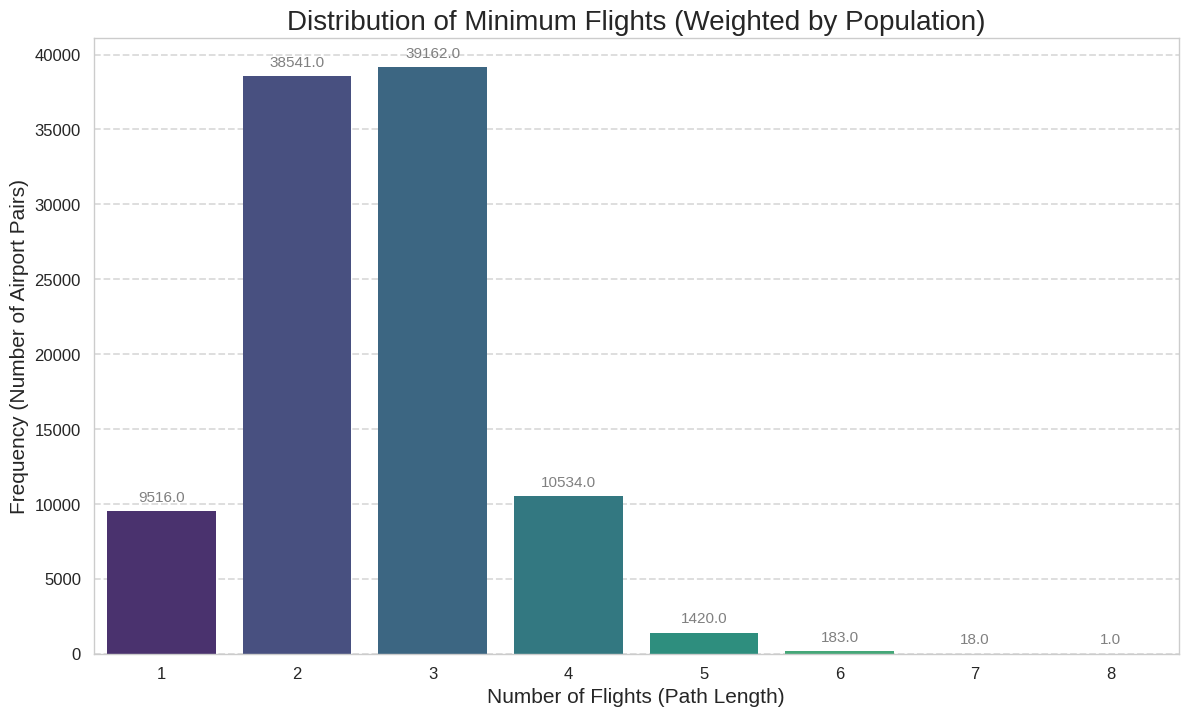

In [3]:
!pip install geonamescache -q

import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
import geonamescache

warnings.simplefilter(action='ignore', category=FutureWarning)

!wget -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat -O routes.dat
!wget -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat -O airports.dat

#Data loading and cleaning
airports_cols = [
    'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'
]
routes_cols = [
    'Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport',
    'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'
]
airports = pd.read_csv('airports.dat', header=None, names=airports_cols, na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=routes_cols, na_values='\\N')
routes.dropna(subset=['Source airport ID', 'Destination airport ID'], inplace=True)
routes['Source airport ID'] = routes['Source airport ID'].astype(int)
routes['Destination airport ID'] = routes['Destination airport ID'].astype(int)

#retreive population data from geonamescache library
gc = geonamescache.GeonamesCache()

cities_data = gc.get_cities()
countries_data = gc.get_countries()

country_code_map = {code: data['name'] for code, data in countries_data.items()}

cities_df = pd.DataFrame.from_dict(cities_data.values())

cities_df['country_full'] = cities_df['countrycode'].map(country_code_map)

cities = cities_df[['name', 'country_full', 'population']]
cities.rename(columns={'name': 'City', 'country_full': 'Country', 'population': 'Population'}, inplace=True)
cities.dropna(inplace=True)

airports['city_lower'] = airports['City'].str.lower()
airports['country_lower'] = airports['Country'].str.lower()
cities['city_lower'] = cities['City'].str.lower()
cities['country_lower'] = cities['Country'].str.lower()

airports_with_pop = pd.merge(airports, cities, on=['city_lower', 'country_lower'], how='left')

default_population = 1000
airports_with_pop['Population'].fillna(default_population, inplace=True)

population_map = airports_with_pop.set_index('Airport ID')['Population'].to_dict()

#Airport network graph construction and bias weightage added
G = nx.from_pandas_edgelist(
    routes,
    source='Source airport ID',
    target='Destination airport ID',
    create_using=nx.DiGraph()
)
airport_nodes = list(G.nodes())

weights = [population_map.get(node, default_population) for node in airport_nodes]

#Run simulation
num_samples = 100000
path_lengths = []
no_path_count = 0

print(f"Simulation for {num_samples} random airport pairs")
for _ in tqdm(range(num_samples)):
    pair = random.choices(airport_nodes, weights=weights, k=2)
    source_airport, target_airport = pair[0], pair[1]

    while source_airport == target_airport:
        target_airport = random.choices(airport_nodes, weights=weights, k=1)[0]

    try:
        length = nx.shortest_path_length(G, source=source_airport, target=target_airport)
        path_lengths.append(length)
    except nx.NetworkXNoPath:
        no_path_count += 1

#Analysis and vizualization
if path_lengths:
    average_flights = sum(path_lengths) / len(path_lengths)
    most_common_flights = max(set(path_lengths), key=path_lengths.count)
else:
    average_flights = 0
    most_common_flights = 0

print("\nPopulation-Weighted Analysis Results\n")
print(f"Number of random pairs tested: {num_samples}")
print(f"Pairs with a connecting route: {len(path_lengths)}")
print(f"Pairs with no connecting route: {no_path_count}")
print(f"Average number of flights between connected airports: {average_flights:.2f}")
print(f"Most common number of flights needed: {most_common_flights}")
print("\n")

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(14, 8))
ax = sns.countplot(x=path_lengths, palette='viridis', order=sorted(set(path_lengths)))
plt.title('Distribution of Minimum Flights (Weighted by Population)', fontsize=20)
plt.xlabel('Number of Flights (Path Length)', fontsize=15)
plt.ylabel('Frequency (Number of Airport Pairs)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-2808941269.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities.rename(columns={'name': 'City', 'country_full': 'Country', 'population': 'Population'}, inplace=True)
/tmp/ipython-input-2808941269.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities.dropna(inplace=True)
/tmp/ipython-input-2808941269.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

  0%|          | 0/67240 [00:00<?, ?it/s]

Simulation for 100000 population-weighted pairs using Dijkstra's algorithm


  0%|          | 0/100000 [00:00<?, ?it/s]


Population-Weighted Distance Analysis

Number of random pairs tested: 100000
Pairs with a connecting route: 99245
Pairs with no connecting route: 755
Average shortest travel distance: 8,008.70 km




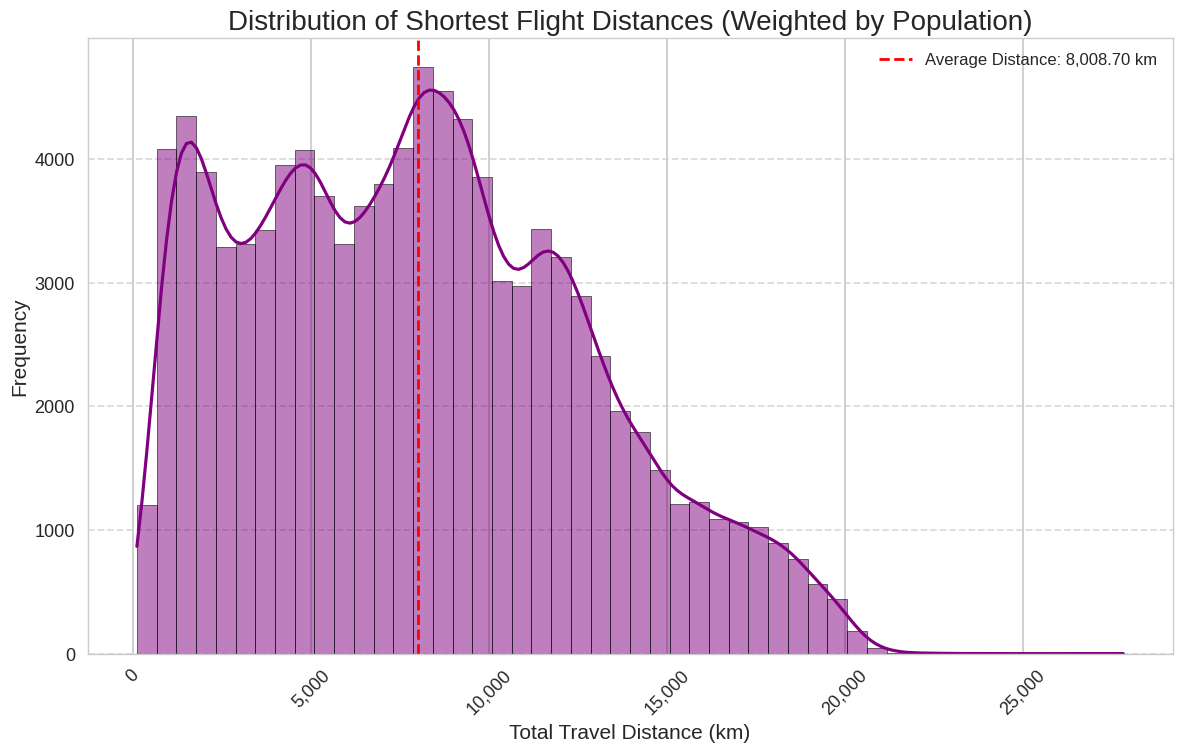

In [4]:
!pip install geonamescache -q

import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
import math
import geonamescache

warnings.simplefilter(action='ignore', category=FutureWarning)

!wget -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat -O routes.dat
!wget -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat -O airports.dat
#Haversine distance between 2 coordinates function
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points on the earth."""
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


#Data loading and cleaning
airports_cols = [
    'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
    'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'
]
routes_cols = [
    'Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport',
    'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'
]
airports = pd.read_csv('airports.dat', header=None, names=airports_cols, na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=routes_cols, na_values='\\N')

airports.dropna(subset=['Latitude', 'Longitude', 'Airport ID'], inplace=True)
routes.dropna(subset=['Source airport ID', 'Destination airport ID'], inplace=True)
airports['Airport ID'] = airports['Airport ID'].astype(int)
routes['Source airport ID'] = routes['Source airport ID'].astype(int)
routes['Destination airport ID'] = routes['Destination airport ID'].astype(int)

airport_coords = {row['Airport ID']: (row['Latitude'], row['Longitude']) for _, row in airports.iterrows()}

#Get population data and merge with airport location data
gc = geonamescache.GeonamesCache()
cities_data = gc.get_cities()
countries_data = gc.get_countries()

country_code_map = {code: data['name'] for code, data in countries_data.items()}
cities_df = pd.DataFrame.from_dict(cities_data.values())
cities_df['country_full'] = cities_df['countrycode'].map(country_code_map)
cities = cities_df[['name', 'country_full', 'population']]
cities.rename(columns={'name': 'City', 'country_full': 'Country', 'population': 'Population'}, inplace=True)
cities.dropna(inplace=True)

airports['city_lower'] = airports['City'].str.lower()
airports['country_lower'] = airports['Country'].str.lower()
cities['city_lower'] = cities['City'].str.lower()
cities['country_lower'] = cities['Country'].str.lower()

airports_with_pop = pd.merge(airports, cities, on=['city_lower', 'country_lower'], how='left')
default_population = 1000
airports_with_pop['Population'].fillna(default_population, inplace=True)
population_map = airports_with_pop.set_index('Airport ID')['Population'].to_dict()

#Airport network graph construction and bias weightage added
G_weighted = nx.DiGraph()
for _, route in tqdm(routes.iterrows(), total=routes.shape[0]):
    source_id = route['Source airport ID']
    dest_id = route['Destination airport ID']
    if source_id in airport_coords and dest_id in airport_coords:
        source_coords = airport_coords[source_id]
        dest_coords = airport_coords[dest_id]
        distance = haversine(source_coords[0], source_coords[1], dest_coords[0], dest_coords[1])
        G_weighted.add_edge(source_id, dest_id, weight=distance)

airport_nodes = list(G_weighted.nodes())
weights = [population_map.get(node, default_population) for node in airport_nodes]

#Run dijkstra's algorithm to find least distance between airports with weighted bias for random selection of airport
num_samples = 100000
path_distances = []
no_path_count = 0

print(f"Simulation for {num_samples} population-weighted pairs using Dijkstra's algorithm")
for _ in tqdm(range(num_samples)):
    pair = random.choices(airport_nodes, weights=weights, k=2)
    source_airport, target_airport = pair[0], pair[1]
    while source_airport == target_airport:
        target_airport = random.choices(airport_nodes, weights=weights, k=1)[0]

    try:
        distance = nx.dijkstra_path_length(G_weighted, source=source_airport, target=target_airport, weight='weight')
        path_distances.append(distance)
    except nx.NetworkXNoPath:
        no_path_count += 1

#Data analysis and visualization
if path_distances:
    average_distance = sum(path_distances) / len(path_distances)
else:
    average_distance = 0

print("\nPopulation-Weighted Distance Analysis\n")
print(f"Number of random pairs tested: {num_samples}")
print(f"Pairs with a connecting route: {len(path_distances)}")
print(f"Pairs with no connecting route: {no_path_count}")
print(f"Average shortest travel distance: {average_distance:,.2f} km")
print("\n")

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(14, 8))
sns.histplot(path_distances, bins=50, kde=True, color='purple')
plt.axvline(average_distance, color='red', linestyle='--', linewidth=2, label=f'Average Distance: {average_distance:,.2f} km')
plt.title('Distribution of Shortest Flight Distances (Weighted by Population)', fontsize=20)
plt.xlabel('Total Travel Distance (km)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.show()